In [55]:
%load_ext autoreload
%autoreload 2

import pickle as pkl
import os
import sys
import string
sys.path.append('../../')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import xgboost

from langdetect import detect
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm_notebook as tqdm

from comscore_task.settings import DATASETS_DIR, STORAGE_DIR

tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
class_mapping = {
    'FB': 0,
    'TW': 1
}
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

In [41]:
df = pd.read_parquet(DATASETS_DIR / 'train_data.parquet')
y_train = df['platform'].replace(class_mapping).values

In [61]:
val_df = pd.read_parquet(DATASETS_DIR / 'val_data_post_content.parquet')
val_target_df = pd.read_parquet(DATASETS_DIR / 'val_data_platform.parquet')
y_val = val_target_df['platform'].replace(class_mapping).values

In [9]:
def preprocess_text(text: str) -> str:
    text = re.sub(r'\n', ' ', text)
    text = text.strip()
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text)
    return text

In [10]:
df.head()

,brand_id,post_content,platform
0,9b39285ec9cf47baaa51d1ea18eec8cc,#LoSéTodo La violación a la intimidad tiene co...,FB
1,18cbba7c95b741e9bb477778c5cce568,Whoopi Goldberg apologizes after saying the Ho...,FB
2,a63ceb8f478e43938416f2a9a1c5bacd,Nochevieja se llama Hogmanay en Escocia y la m...,TW
3,acbba767a3854bd3b324da5a1c896fe6,Kiss my to welcome in the New Years and finger...,TW
4,0dc1b14b735e47c5861dc8238bb218e0,— Hiding in plain sight on a dusty corner of t...,FB


In [49]:
df['preprocessed_post'] = df['post_content'].progress_apply(lambda text: preprocess_text(text))
val_df['preprocessed_post'] = val_df['post_content'].progress_apply(lambda text: preprocess_text(text))

  0%|          | 0/77873 [00:00<?, ?it/s]

  0%|          | 0/9734 [00:00<?, ?it/s]

In [16]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train_sparse = tfidf_vectorizer.fit_transform(df['preprocessed_post'])

In [52]:
models_dir = STORAGE_DIR / 'models'
os.makedirs(models_dir, exist_ok=True)

with open(models_dir / 'tfidf_vectorizer.pkl', 'wb') as f:
    pkl.dump(tfidf_vectorizer, f)

In [50]:
tfidf_val_sparse = tfidf_vectorizer.transform(val_df['preprocessed_post'])

In [18]:
tfidf_train_sparse.shape

(77873, 226118)

In [51]:
tfidf_val_sparse.shape

(9734, 226118)

In [20]:
max_num_components = 2000
svd = TruncatedSVD(max_num_components, random_state=42).fit(tfidf_train_sparse)

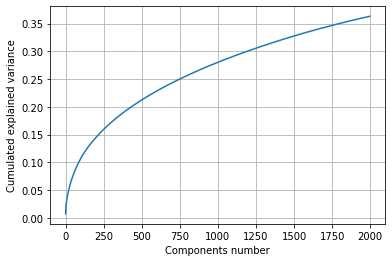

In [21]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Components number')
plt.ylabel('Cumulated explained variance')
plt.grid()

In [27]:
models_dir = STORAGE_DIR / 'models'
os.makedirs(models_dir, exist_ok=True)

with open(models_dir / 'svd.pkl', 'wb') as f:
    pkl.dump(svd, f)

In [28]:
x_svd_tfidf_train = svd.transform(tfidf_train_sparse)

In [53]:
x_svd_tfidf_val = svd.transform(tfidf_val_sparse)

In [46]:
model = xgboost.XGBClassifier()
model.fit(x_svd_tfidf_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [79]:
with open(models_dir / 'xgb_model.pkl', 'wb') as f:
    pkl.dump(model, f)

In [62]:
x_svd_tfidf_val.shape

(9734, 2000)

In [63]:
y_val.shape

(9734,)

In [68]:
list(class_mapping.keys())

['FB', 'TW']

In [69]:
y_pred = model.predict(x_svd_tfidf_val)
print(classification_report(y_val, y_pred, target_names=list(class_mapping.keys())))

              precision    recall  f1-score   support

          FB       0.67      0.68      0.67      4734
          TW       0.69      0.68      0.69      5000

    accuracy                           0.68      9734
   macro avg       0.68      0.68      0.68      9734
weighted avg       0.68      0.68      0.68      9734

